In [65]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis,ProtParamData
import matplotlib.pyplot as plt
import seaborn as sns

import os
from Bio import SeqIO
import numpy as np
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import PercentFormatter

In [7]:
PDZ = pd.read_excel("OMP25_modeling_110720019.xlsx")

In [8]:
import re
W_RPattern = re.compile(r'W\wR')
Y_CPattern = re.compile(r'(Y\wC)|(YY\w)')
WG_GPattern = re.compile(r'(WG\wG)|(W\wQG)|(\wGQG)|(\w\wQG)|(WG\w\w)|(W\w\wG)|(W\wQ\w)')
def find_cdr1(sequence):
    # STARTING POS. OF CDR1:
    left_area = sequence[20:26]  # look from pos. 20 - 26 of seq (0-based)
    left_cdr = -1
    la_i = left_area.find('SC')
    if la_i < 0:
        # didn't find 'SC', look for 'C'
        la_i = left_area.find('C')
    else:
        la_i += 1  # 'C' is our marker, so advance past 'S'
    if la_i >= 0:
        left_cdr = la_i + 20 + 5  # CDR1 starts at 'C' + 5 (add 20 to put it back in the full sequence)

    # ENDING POS. OF CDR1:
    right_area = sequence[32:40]  # look from pos. 32 - 40 of seq (0-based)
    ra_i = -1
    right_cdr = -1
    W_R = W_RPattern.search(right_area)
    if W_R != None:
        # if we found 'WXR', find its index
        ra_i = right_area.find(W_R[0])

    else:
        ra_i = right_area.find('W')  # didn't find 'WXR', look for 'W'
    if ra_i >= 0:
        right_cdr = ra_i + 32 - 1 + 1  # CDR1 ends at 'W' - 1 (add 32 to put it back in the full sequence)

    # check if st/end found and if not follow rules:
    if left_cdr == -1 and right_cdr == -1:
        left_cdr = 28
        right_cdr = 36
    elif left_cdr == -1:
        left_cdr = right_cdr - 8
    elif right_cdr == -1:
        right_cdr = left_cdr + 8

    return [left_cdr,right_cdr]

def find_cdr2(sequence):
    # STARTING POS. OF CDR2:
    left_area = sequence[32:40]  # look from pos. 32 - 40 of seq (0-based)
    la_i = -1
    left_cdr = -1
    W_R = W_RPattern.search(left_area)
    if W_R != None:
        # if we found 'WXR', find its index
        la_i = W_R.start(0)
    else:
        la_i = left_area.find('W')  # didn't find 'WXR', look for 'W'
    if la_i >= 0:
        left_cdr = la_i + 32 + 14  # CDR2 starts at 'W' + 14 (add 32 to put it back in the full sequence)

    # ENDING POS. OF CDR2:
    right_area = sequence[63:72]  # look from pos. 63 - 72 of seq (0-based)
    right_cdr = -1
    ra_i = right_area.find('RF')
    if ra_i >= 0:
        right_cdr = ra_i + 63 - 8 + 1  # CDR2 ends at 'R' - 8 (add 63 to put it back in the full sequence)

    # check if st/end found and if not follow rules:
    if left_cdr == -1 and right_cdr == -1:
        left_cdr = 51
        right_cdr = 60
    elif left_cdr == -1:
        left_cdr = right_cdr - 9
    elif right_cdr == -1:
        right_cdr = left_cdr + 9

    return [left_cdr,right_cdr]

def find_cdr3(sequence):
    left_area = sequence[90:105]
    la_i = -1
    left_cdr = -1
    Y_C = Y_CPattern.search(left_area)
    if Y_C != None:
        # if we found 'YXR', find its index
        la_i = Y_C.start(0)+2
    else:
        la_i = left_area.find('C')  # didn't find 'YXC', look for 'C'

    if la_i >= 0:
        left_cdr = la_i + 90 + 3
    n = len(sequence) - 1
    n1 = n - 14
    subtract_amount = 1
    right_area = sequence[n1:n - 4]
    ra_i = -1
    right_cdr = -1
    WG_G = WG_GPattern.search(right_area)
    if WG_G != None:
        ra_i = WG_G.start(0)

    if ra_i >= 0:
        right_cdr = ra_i + n1 - subtract_amount + 1  # CDR3 ends at 'W' - 1 (or 'Q' - 3) (add n-14 to put it back in the full sequence)
    # check
    if left_cdr == -1 and right_cdr == -1:
        left_cdr = n - 21
        right_cdr = n - 10
    elif left_cdr == -1:
        left_cdr = right_cdr - 11
    elif right_cdr == -1:
        if left_cdr + 11 <= n:
            right_cdr = left_cdr + 11
        else:
            right_cdr = n
    if left_cdr > right_cdr:
        left_cdr = n - 1
        right_cdr = n
    return [left_cdr,right_cdr]

def find_cdr1_seq(x):
    cdr1 = find_cdr1(x)
    return x[cdr1[0]:cdr1[1]]
def find_cdr2_seq(x):
    cdr2 = find_cdr2(x)
    return x[cdr2[0]:cdr2[1]]
def find_cdr3_seq(x):
    cdr3 = find_cdr3(x)
    return x[cdr3[0]:cdr3[1]]
def find_fr1_seq(x):
    cdr1_start = find_cdr1(x)[0]
    return x[:cdr1_start]

def find_fr2_seq(x):
    cdr1_end = find_cdr1(x)[1]
    cdr2_start = find_cdr2(x)[0]
    return x[cdr1_end:cdr2_start]

def find_fr3_seq(x):
    cdr2_end = find_cdr2(x)[1]
    cdr3_start = find_cdr3(x)[0]
    
    return x[cdr2_end:cdr3_start]

def find_fr4_seq(x):
    cdr3_end = find_cdr3(x)[1]
    return x[cdr3_end:]
def extract_more_cdr3_region(sequence,cdr3):
    start,end  = re.search(cdr3,sequence).span(0)
    return sequence[start - 5:end+4]

In [9]:
PDZ['CDR1'] = PDZ['sequence'].apply(lambda x: find_cdr1_seq(x))
PDZ['CDR2'] = PDZ['sequence'].apply(lambda x: find_cdr2_seq(x))
PDZ['CDR3'] = PDZ['sequence'].apply(lambda x: find_cdr3_seq(x))

In [10]:
PDZ = PDZ[PDZ.apply(lambda x: x['highph']==2 or x['salt'] == 2,1)]

In [11]:
Unique_CDR3 = PDZ.drop_duplicates("CDR3")
Unique_CDR3['YYC_CDR3'] = Unique_CDR3['CDR3'].apply(lambda x: "YYCAA" + x +"WGQG")
Unique_CDR3['real_YYC_CDR3'] = Unique_CDR3.apply(lambda x: extract_more_cdr3_region(x['sequence'],x['CDR3']),1)
Unique_CDR3['CDR3 PI'] = Unique_CDR3['CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
Unique_CDR3['CDR3 Length'] = Unique_CDR3['CDR3'].apply(lambda x: len(x))
Unique_CDR3['CDR3 Cysteine'] = Unique_CDR3['CDR3'].apply(lambda x: x.count("C"))
Unique_CDR3['CDR3 Hydrophobicity'] = Unique_CDR3['CDR3'].apply(lambda x: ProteinAnalysis(x).gravy())
max_hydro = Unique_CDR3['CDR3 Hydrophobicity'].max()
min_hydro = Unique_CDR3['CDR3 Hydrophobicity'].min()
Unique_CDR3['Normalized CDR3 Hydrophobicity'] = 2* (Unique_CDR3['CDR3 Hydrophobicity'] - min_hydro)/(max_hydro-min_hydro) -1
max_pi = Unique_CDR3['CDR3 PI'].max()
min_pi = Unique_CDR3['CDR3 PI'].min()
Unique_CDR3['Normalized CDR3 PI'] = 2* (Unique_CDR3['CDR3 PI'] - min_pi)/(max_pi-min_pi) -1
Unique_CDR3.to_csv("PDZ_Unique_CDR3_property.csv")

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying t

In [9]:
PDZ.to_csv("PDZ.csv")

## Identification Summary

In [8]:
print("Unique CDR3:{}".format(PDZ['CDR3'].unique().shape[0]))
print("Unique CDR:{}".format(PDZ[['CDR1','CDR2','CDR3']].apply(lambda x: '-'.join(x.values),1).unique().shape[0]))
print("Unique Seqs:{}".format(PDZ.shape[0]))

Unique CDR3:230
Unique CDR:495
Unique Seqs:2379


## Sequence Property

In [14]:
PDZ['Sequence PI'] = PDZ['sequence'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
PDZ['Sequence Hydropathy'] = PDZ['sequence'].apply(lambda x: ProteinAnalysis(x).gravy())
PDZ['CDR1 PI'] = PDZ['CDR1'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
PDZ['CDR2 PI'] = PDZ['CDR2'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
PDZ['CDR3 PI'] = PDZ['CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
PDZ['CDR1 Hydropathy'] = PDZ['CDR1'].apply(lambda x: ProteinAnalysis(x).gravy())
PDZ['CDR2 Hydropathy'] = PDZ['CDR2'].apply(lambda x: ProteinAnalysis(x).gravy())
PDZ['CDR3 Hydropathy'] = PDZ['CDR3'].apply(lambda x: ProteinAnalysis(x).gravy())

## HighpH Low Affinity Vs HighpH Affinity Sequence property comparison

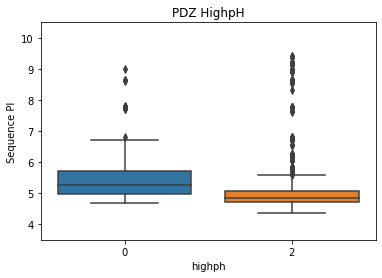

In [13]:
sns.boxplot(x = 'highph',y='Sequence PI',data = PDZ[(PDZ['highph']==0)|(PDZ['highph']==2)])
plt.ylim((3.5,10.5))
plt.title("PDZ HighpH")
plt.savefig("PDZ_Figures/Sequence PI.svg",format='svg')

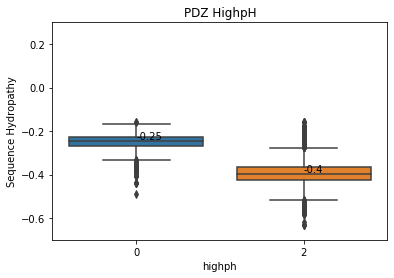

In [14]:
sns.boxplot(x = 'highph',y='Sequence Hydropathy',data = PDZ[(PDZ['highph']==0)|(PDZ['highph']==2)])
plt.ylim((-0.7,0.3))
low_median = PDZ[PDZ['highph']==0]['Sequence Hydropathy'].median()
high_median = PDZ[PDZ['highph']==2]['Sequence Hydropathy'].median()

plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))
plt.title("PDZ HighpH")
plt.savefig("PDZ_Figures/Sequence Hydropathy.svg",format='svg')

In [15]:
stats.ks_2samp(PDZ[PDZ['highph']==0]['Sequence Hydropathy'].values,PDZ[PDZ['highph']==2]['Sequence Hydropathy'].values)

Ks_2sampResult(statistic=0.7778678583932724, pvalue=2.3314683517128287e-15)

In [16]:
stats.ttest_ind(PDZ[PDZ['highph']==0]['Sequence Hydropathy'].values,PDZ[PDZ['highph']==2]['Sequence Hydropathy'].values)

Ttest_indResult(statistic=38.530431612677056, pvalue=1.9329269359754201e-240)

## Unique HighpH CDR Feature

In [13]:
PDZ['CDR'] = PDZ[['CDR1','CDR2','CDR3']].apply(lambda x: "".join(x.values),1)
HighpH = PDZ[PDZ['highph']!='/']
Unique_CDR_HighpH = HighpH.drop_duplicates("CDR")
Unique_CDR_HighpH['CDR PI'] = Unique_CDR_HighpH['CDR'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


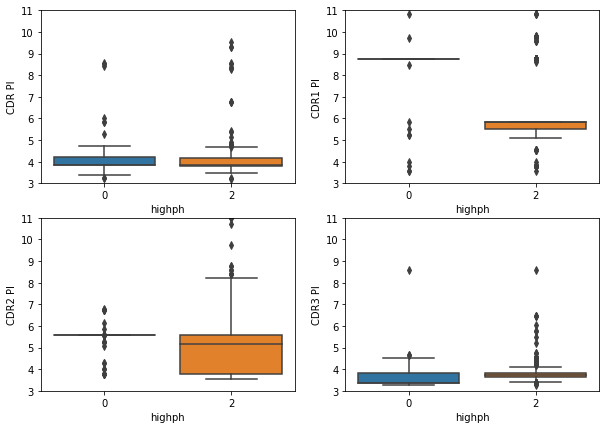

In [18]:
plt.figure(figsize=(10,7))
plt.subplot(221)
sns.boxplot(x = 'highph',y='CDR PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['highph']==0)|(Unique_CDR_HighpH['highph']==2)])
plt.ylim((3,11))
plt.subplot(222)
sns.boxplot(x = 'highph',y='CDR1 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['highph']==0)|(Unique_CDR_HighpH['highph']==2)])
plt.ylim((3,11))
plt.subplot(223)
sns.boxplot(x = 'highph',y='CDR2 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['highph']==0)|(Unique_CDR_HighpH['highph']==2)])
plt.ylim((3,11))
plt.subplot(224)
sns.boxplot(x = 'highph',y='CDR3 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['highph']==0)|(Unique_CDR_HighpH['highph']==2)])
plt.ylim((3,11))
plt.savefig("PDZ_Figures/PDZ_CDR_PI.svg",format="svg")

### CDR3 Head Region AA Composition


In [17]:
Unique_CDR_HighpH['Head_CDR3'] = Unique_CDR_HighpH['CDR3'].apply(lambda x: x[:-4])
Unique_CDR_HighpH['Head_CDR3 PI'] = Unique_CDR_HighpH['Head_CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point() if x!="" else 0)
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR_HighpH['head_'+aa] = Unique_CDR_HighpH['Head_CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR_HighpH[aa] = Unique_CDR_HighpH['CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR_HighpH['head_'+aa+"_dens"] = Unique_CDR_HighpH['Head_CDR3'].apply(lambda x: x.count(aa)/(len(x)-4))

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

### Amino acid concentration change


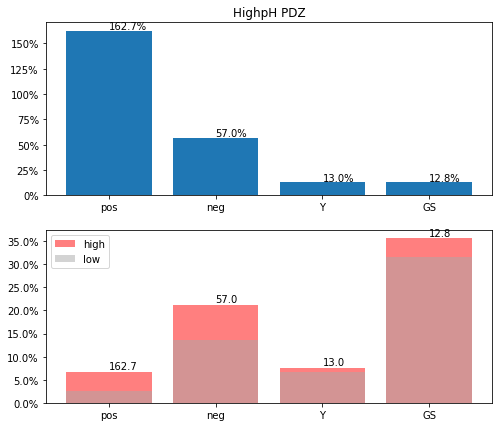

In [19]:

plt.figure(figsize=(8,7))
plt.subplot(211)
plt.title("HighpH PDZ")

high = Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==2][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==2]['CDR3'].apply(lambda x:len(x)-4).sum()
low = Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==0][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==0]['CDR3'].apply(lambda x:len(x)-4).sum()
low['pos'] = low[['head_K','head_R','head_H']].sum()
low['neg'] = low[['head_D','head_E']].sum()
low['Y'] = low[['head_Y']].sum()
low['GS'] =  low[['head_G','head_S']].sum()


high['pos'] = high[['head_K','head_R','head_H']].sum()
high['neg'] = high[['head_D','head_E']].sum()
high['Y'] = high[['head_Y']].sum()
high['GS'] =  high[['head_G','head_S']].sum()


selected_low = low.loc[['pos','neg','Y',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("PDZ_Figures/PDZ_CDR3_AA_group_Concentration(Unique CDR).svg",format='svg')

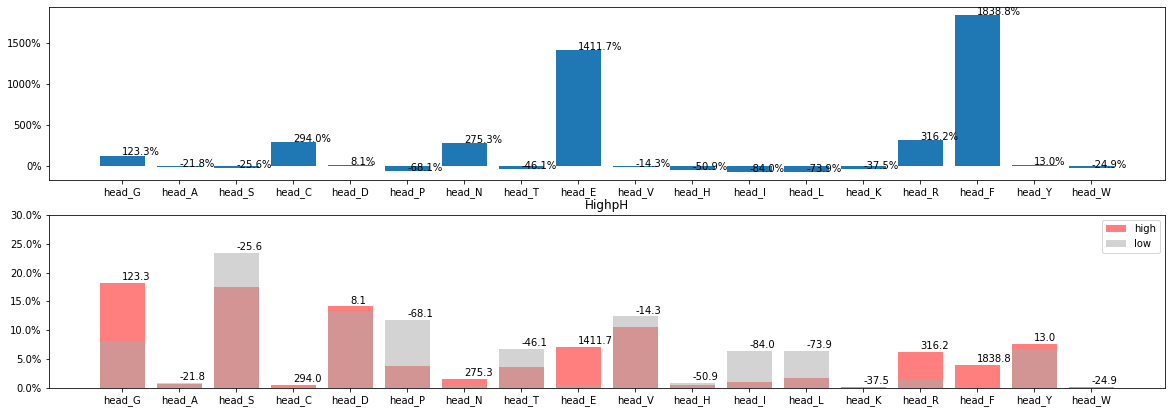

In [22]:

plt.figure(figsize=(20,7))
plt.subplot(211)

high = Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==2][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==2]['CDR3'].apply(lambda x:len(x)-4).sum()
low = Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==0][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==0]['CDR3'].apply(lambda x:len(x)-4).sum()
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.savefig("ALL_Concentration_head_cdr3_percentage_change.svg",format='svg')

plt.subplot(212)

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.ylim(ymax=0.3)

plt.legend()
plt.savefig("PDZ_Figures/PDZ_CDR3_AA_Concentration(Unique CDR).svg",format='svg')

In [23]:
def counts(data):
    aa_counts = (data[["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/data['CDR3'].apply(lambda x:len(x)-4).sum()).sort_values(ascending=False)
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

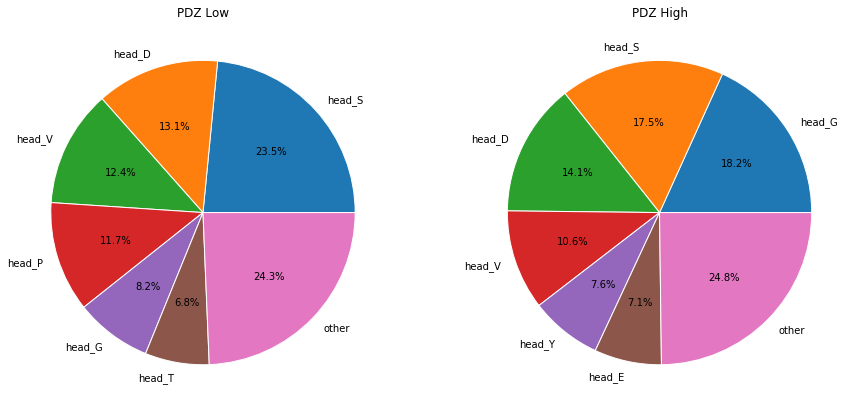

In [25]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts(Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==0])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("PDZ Low")
plt.subplot(122)
aa,aa_counts = counts(Unique_CDR_HighpH[Unique_CDR_HighpH['highph']==2])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("PDZ High")
plt.savefig("PDZ_Figures/PieChart PDZ CDR3 AA percentage(Unique CDR).svg",format='svg')

## Unique HighpH CDR3 Feature

In [12]:
Unique_CDR3_HighpH = HighpH.groupby("CDR3").filter(lambda x:x['highph'].unique().shape[0]<2).drop_duplicates("CDR3")

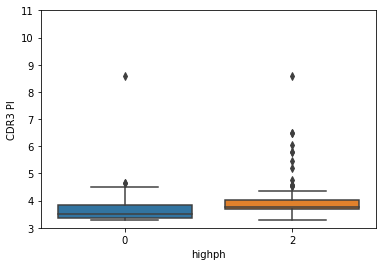

In [20]:
sns.boxplot(x = 'highph',y='CDR3 PI',data = Unique_CDR3_HighpH[(Unique_CDR3_HighpH['highph']==0)|(Unique_CDR3_HighpH['highph']==2)])
plt.ylim((3,11))
plt.savefig("PDZ_Figures\PDZ_CDR3_PI.svg",format='svg')

### CDR3 Head Region AA Composition

In [17]:
Unique_CDR3_HighpH['Head_CDR3'] = Unique_CDR3_HighpH['CDR3'].apply(lambda x: x[:-4])
Unique_CDR3_HighpH['Head_CDR3 PI'] = Unique_CDR3_HighpH['Head_CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point() if x!="" else 0)
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH['head_'+aa] = Unique_CDR3_HighpH['Head_CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH[aa] = Unique_CDR3_HighpH['CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH['head_'+aa+"_dens"] = Unique_CDR3_HighpH['Head_CDR3'].apply(lambda x: x.count(aa)/len(x) if x!="" else 0)
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH[aa+"_dens"] = Unique_CDR3_HighpH['CDR3'].apply(lambda x: x.count(aa)/len(x) )

Absolute Number change

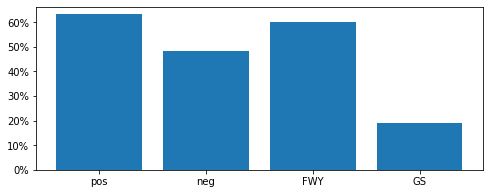

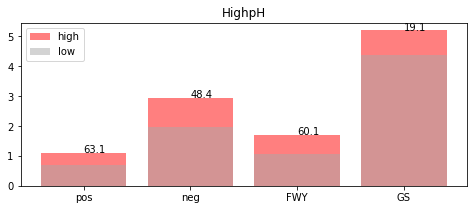

In [22]:

plt.figure(figsize=(8,3))
high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low['pos'] = low[['head_K','head_R','head_H']].sum()
low['neg'] = low[['head_D','head_E']].sum()
low['FWY'] = low[['head_F','head_W','head_Y']].sum()
low['GS'] =  low[['head_G','head_S']].sum()


high['pos'] = high[['head_K','head_R','head_H']].sum()
high['neg'] = high[['head_D','head_E']].sum()
high['FWY'] = high[['head_F','head_W','head_Y']].sum()
high['GS'] =  high[['head_G','head_S']].sum()


selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.legend()

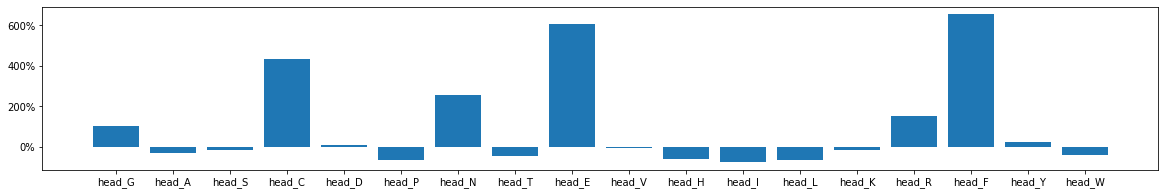

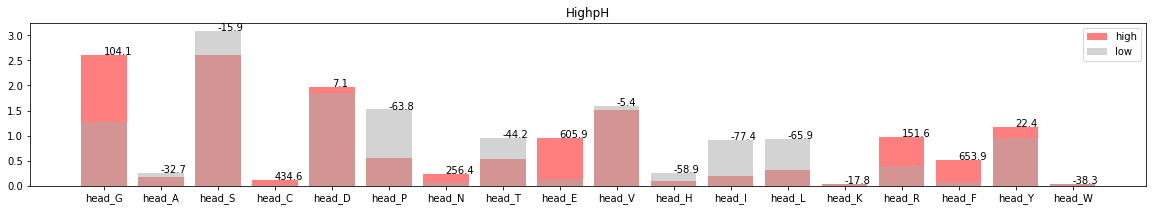

In [23]:

plt.figure(figsize=(20,3))

high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.savefig("ALL_Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(20,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.legend()

### Amino acid concentration change

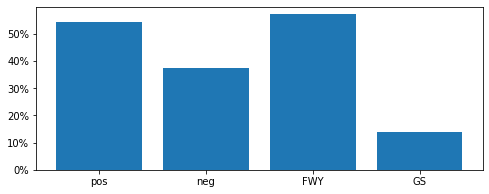

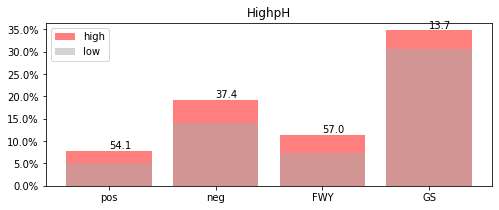

In [24]:

plt.figure(figsize=(8,3))
high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low['pos'] = low[['head_K_dens','head_R_dens','head_H_dens']].sum()
low['neg'] = low[['head_D_dens','head_E_dens']].sum()
low['FWY'] = low[['head_F_dens','head_W_dens','head_Y_dens']].sum()
low['GS'] =  low[['head_G_dens','head_S_dens']].sum()


high['pos'] = high[['head_K_dens','head_R_dens','head_H_dens']].sum()
high['neg'] = high[['head_D_dens','head_E_dens']].sum()
high['FWY'] = high[['head_F_dens','head_W_dens','head_Y_dens']].sum()
high['GS'] =  high[['head_G_dens','head_S_dens']].sum()


selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.legend()

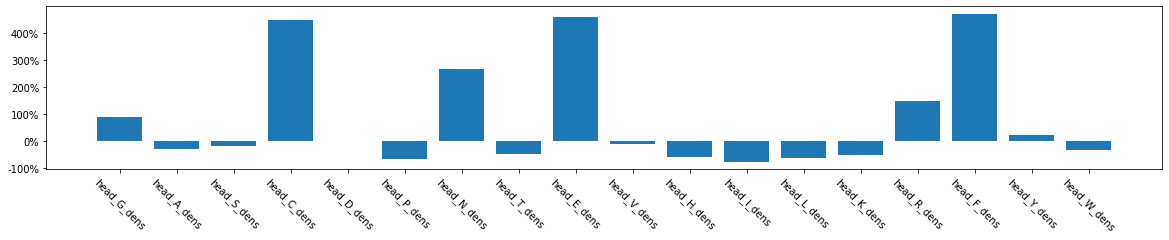

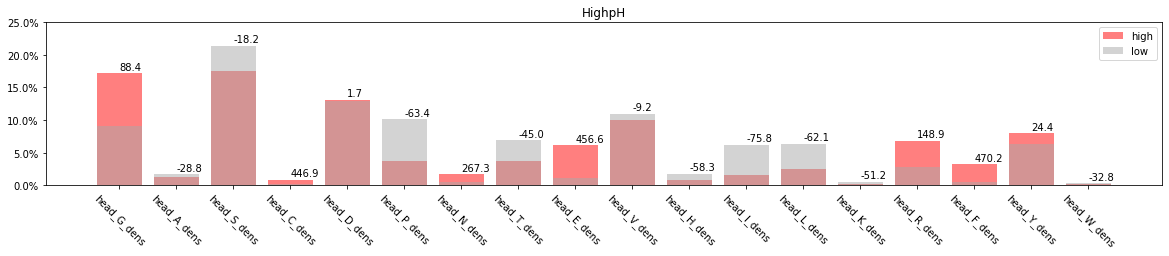

In [28]:

plt.figure(figsize=(20,3))

high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
#plt.savefig("ALL_Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(20,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.title("HighpH")
plt.ylim(ymax=0.25)
plt.legend()

In [364]:
Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3']

2       RGGGSSVDSEYDVGEFEYDY
4            RTLDGLECGGSHYDY
6        TLGDSVDLDSDADPRGYDY
34      RGGGTSVDSDYDVEEFEYDY
44       AIGSTVDSYSPSDPLEYDY
                ...         
6224    RGGGSSVDSEYDAGEFEYDY
6225    RGGGSSVDSEYAVGEFEYDY
6261     HRDYSGSTVDPPNQSEYDY
6274     RSFMVSGYSCNSSPHDYDY
6636       DPRVHYYGGRCDDEYDF
Name: CDR3, Length: 107, dtype: object

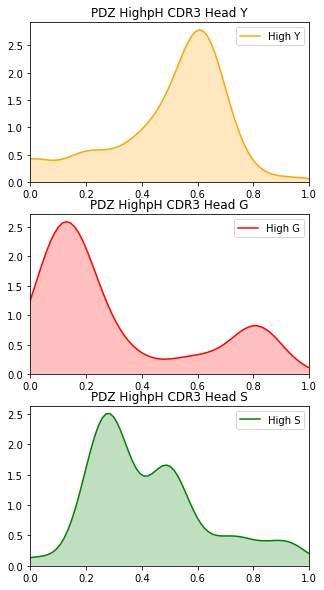

In [365]:
high_G=[]
high_Y=[]
high_S=[]
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3']:
    if not ("Y" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='Y':
                pos.append(i/(len(cdr3)-4))

    high_Y += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3']:
    if not ("G" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='G':
                pos.append(i/(len(cdr3)-4))

    high_G += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3']:
    if not ("S" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='S':
                pos.append(i/(len(cdr3)-4))

    high_S += pos

low_G=[]
low_Y=[]
low_S=[]

for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0]['CDR3']:
    if not ("Y" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='Y':
                pos.append(i/(len(cdr3)-4))

    low_Y += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0]['CDR3']:
    if not ("G" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='G':
                pos.append(i/(len(cdr3)-4))

    low_G += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0]['CDR3']:
    if not ("S" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='S':
                pos.append(i/(len(cdr3)-4))

    low_S += pos

plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title("PDZ HighpH CDR3 Head Y")

sns.distplot(high_Y,hist=False,label='High Y',kde_kws={'shade':True},color='orange')
#sns.distplot(low_Y,hist=False,label='Low Y',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(312)
plt.title("PDZ HighpH CDR3 Head G")
sns.distplot(high_G,hist=False,label='High G',kde_kws={'shade':True},color='red')
#sns.distplot(low_G,hist=False,label='Low G',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.legend()
#plt.savefig("HSA_Figures\HSA_YGS_CDR3_head_position.svg",format='svg')
plt.subplot(313)
plt.title("PDZ HighpH CDR3 Head S")

sns.distplot(high_S,hist=False,label='High S',kde_kws={'shade':True},color='green')
#sns.distplot(low_S,hist=False,label='Low S',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()

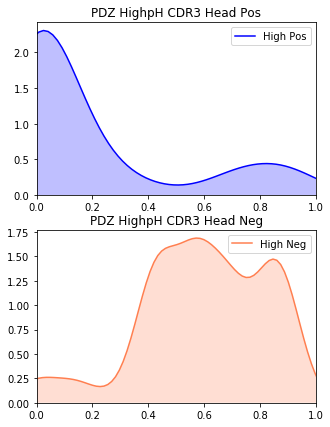

In [367]:
high_p=[]
high_n=[]

for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3']:
    if not ("R" in cdr3 or "K" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr3)-4))

    high_p += pos
    
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3']:
    if not ("D" in cdr3 or "E" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr3)-4))

    high_n += pos
low_p=[]
low_n=[]

for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0]['CDR3']:
    if not ("R" in cdr3 or "K" in cdr3 ):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr3)-4))

    low_p += pos
    
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==0]['CDR3']:
    if not ("D" in cdr3 or "E" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr3)-4))

    low_n += pos
plt.figure(figsize=(5,7))
plt.subplot(211)
plt.title("PDZ HighpH CDR3 Head Pos")
sns.distplot(high_p,hist=False,label='High Pos',kde_kws={'shade':True},color='blue')
#sns.distplot(low_p,hist=False,label='Low Pos',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(212)
plt.title("PDZ HighpH CDR3 Head Neg")
sns.distplot(high_n,hist=False,label='High Neg',kde_kws={'shade':True},color='coral')
#sns.distplot(low_n,hist=False,label='Low Neg',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()

## Unique HighpH CDR1 Feature

In [313]:
def counts_2(data):
    aa_counts = data[[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0).sort_values(ascending=False)
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

In [315]:
Unique_CDR1_HighpH = HighpH.groupby("CDR1").filter(lambda x:x['highph'].unique().shape[0]<2).drop_duplicates("CDR1")

### CDR1 Region

In [316]:

for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR1_HighpH[aa] = Unique_CDR1_HighpH['CDR1'].apply(lambda x: x.count(aa))

for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR1_HighpH[aa+"_dens"] = Unique_CDR1_HighpH['CDR1'].apply(lambda x: x.count(aa)/len(x) )

Amino acid concentration change

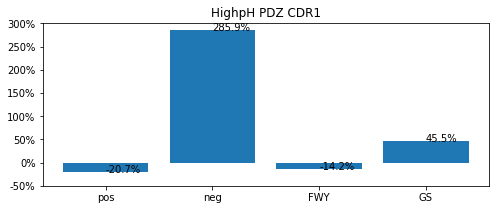

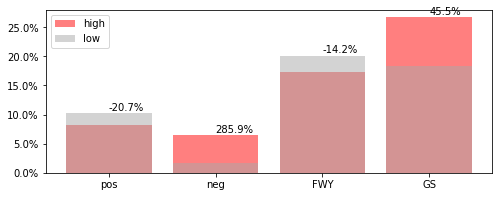

In [320]:

plt.figure(figsize=(8,3))
high = Unique_CDR1_HighpH[Unique_CDR1_HighpH['highph']==2][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low = Unique_CDR1_HighpH[Unique_CDR1_HighpH['highph']==0][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low['pos'] = low[['K_dens','R_dens','H_dens']].sum()
low['neg'] = low[['D_dens','E_dens']].sum()
low['FWY'] = low[['F_dens','W_dens','Y_dens']].sum()
low['GS'] =  low[['G_dens','S_dens']].sum()


high['pos'] = high[['K_dens','R_dens','H_dens']].sum()
high['neg'] = high[['D_dens','E_dens']].sum()
high['FWY'] = high[['F_dens','W_dens','Y_dens']].sum()
high['GS'] =  high[['G_dens','S_dens']].sum()



selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.ylim(ymin=-0.5)
plt.title("HighpH PDZ CDR1")

for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("GST_Figures/AA_group_CDR1_Concentration.svg",format='svg')

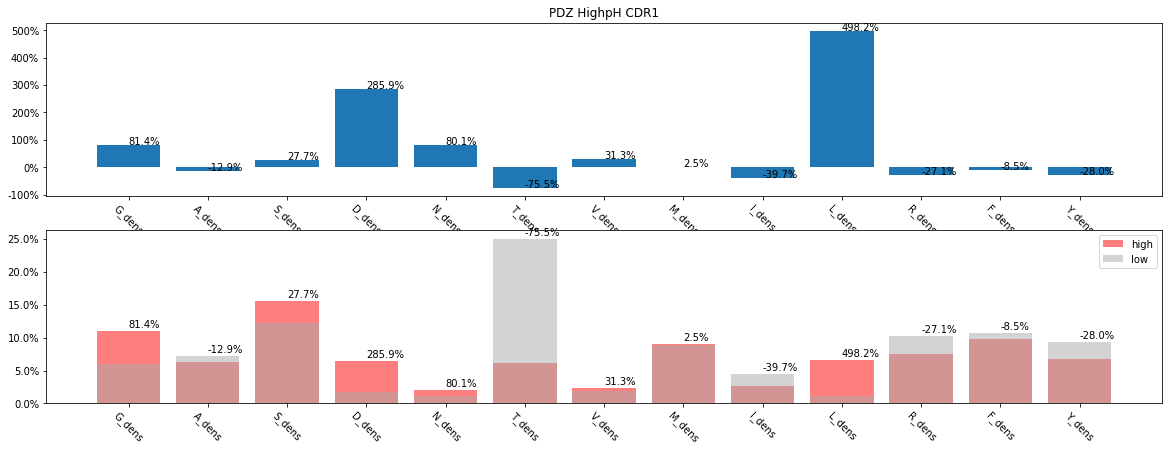

In [324]:

plt.figure(figsize=(20,7))
plt.subplot(211)
high = Unique_CDR1_HighpH[Unique_CDR1_HighpH['highph']==2][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR1_HighpH[Unique_CDR1_HighpH['highph']==0][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.title("PDZ HighpH CDR1")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)

plt.legend()
plt.savefig("PDZ_Figures/AA_CDR1_Concentration.svg",format='svg')

## Unique HighpH CDR2 Feature

In [328]:
Unique_CDR2_HighpH = HighpH.groupby("CDR2").filter(lambda x:x['highph'].unique().shape[0]<2).drop_duplicates("CDR2")

### CDR2 Region

In [330]:
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR2_HighpH[aa] = Unique_CDR2_HighpH['CDR2'].apply(lambda x: x.count(aa))

for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR2_HighpH[aa+"_dens"] = Unique_CDR2_HighpH['CDR2'].apply(lambda x: x.count(aa)/len(x) )

Amino acid concentration change

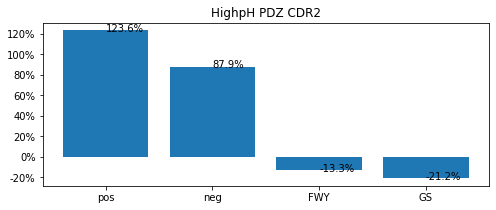

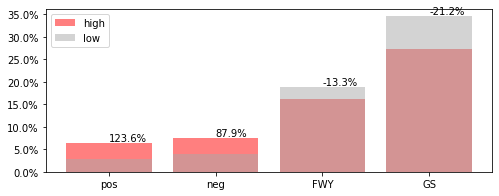

In [333]:

plt.figure(figsize=(8,3))
high = Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==2][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low = Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==0][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low['pos'] = low[['K_dens','R_dens','H_dens']].sum()
low['neg'] = low[['D_dens','E_dens']].sum()
low['FWY'] = low[['F_dens','W_dens','Y_dens']].sum()
low['GS'] =  low[['G_dens','S_dens']].sum()


high['pos'] = high[['K_dens','R_dens','H_dens']].sum()
high['neg'] = high[['D_dens','E_dens']].sum()
high['FWY'] = high[['F_dens','W_dens','Y_dens']].sum()
high['GS'] =  high[['G_dens','S_dens']].sum()



selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.title("HighpH PDZ CDR2")

for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("PDZ_Figures/AA_group_CDR2_Concentration.svg",format='svg')

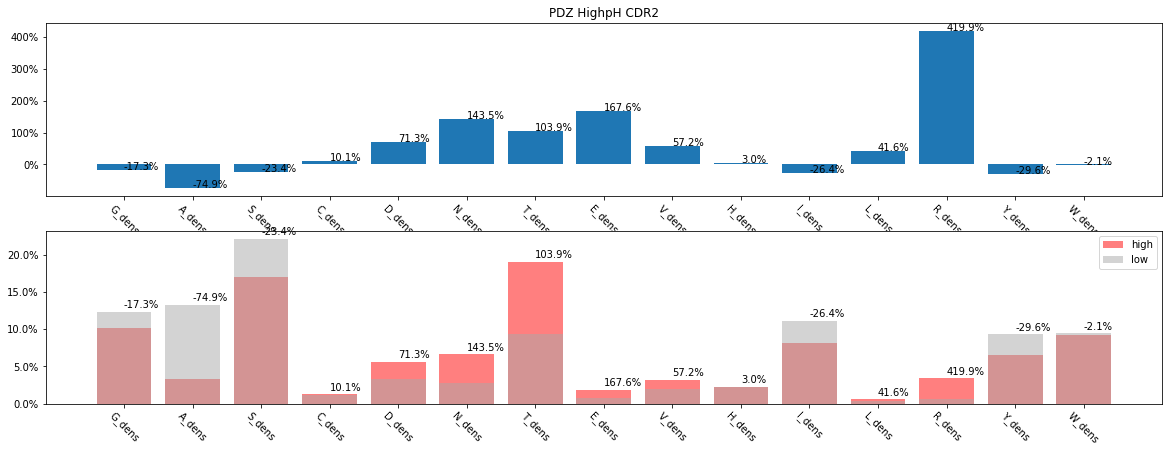

In [335]:

plt.figure(figsize=(20,7))
plt.subplot(211)
high = Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==2][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==0][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.title("PDZ HighpH CDR2")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)

plt.legend()
plt.savefig("PDZ_Figures/AA_CDR2_Concentration.svg",format='svg')

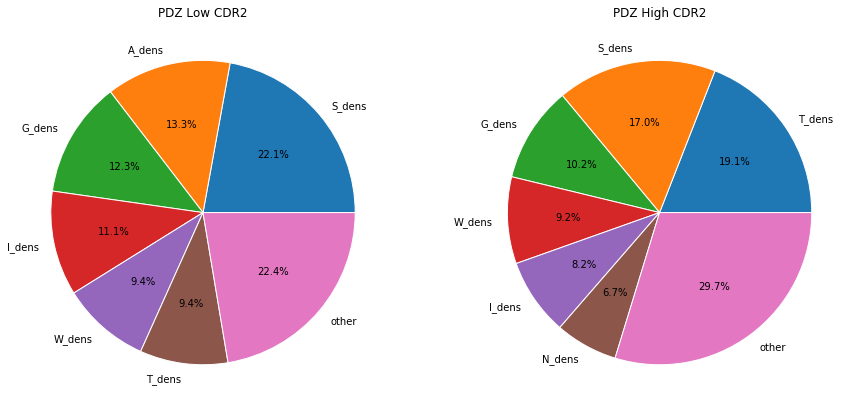

In [337]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts_2(Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==0])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("PDZ Low CDR2")
plt.subplot(122)
aa,aa_counts = counts_2(Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==2])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("PDZ High CDR2")
plt.savefig("PDZ_Figures\PieChart PDZ CDR2 AA percentage.svg",format='svg')

## Comparison CDR3,3 Antigen

In [107]:
HSA_Unique_CDR3_HighpH = pd.read_csv("HSA_Unique_CDR3_HighpH.csv")
GST_Unique_CDR3_HighpH = pd.read_csv("GST_Unique_CDR3_HighpH.csv")

In [20]:
HSA_Unique_CDR3_HighpH.shape

(1353, 23)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

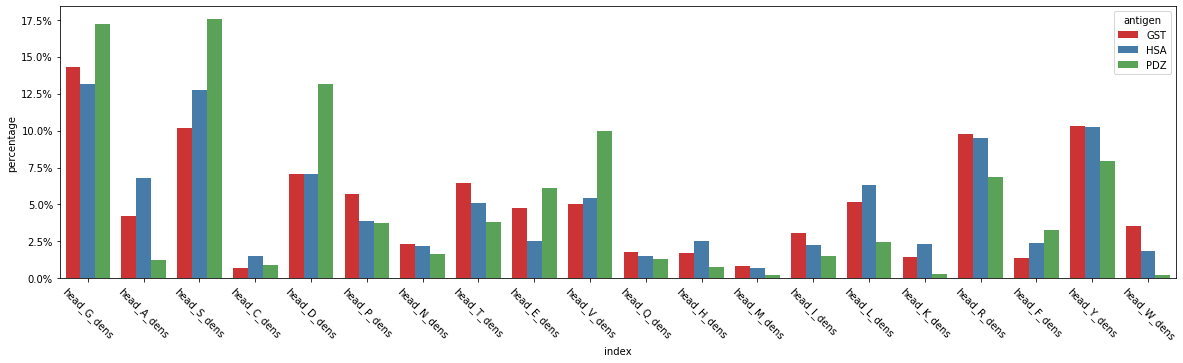

In [26]:

plt.figure(figsize=(20,5))

high_pdz = pd.DataFrame(Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)).reset_index()
high_pdz['Antigen'] = np.repeat("PDZ",high_pdz.shape[0])
high_gst = pd.DataFrame(GST_Unique_CDR3_HighpH[GST_Unique_CDR3_HighpH['HighpH']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)).reset_index()
high_gst['Antigen'] = np.repeat("GST",high_pdz.shape[0])
high_hsa= pd.DataFrame(HSA_Unique_CDR3_HighpH[HSA_Unique_CDR3_HighpH['HighpH']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)).reset_index()
high_hsa['Antigen'] = np.repeat("HSA",high_pdz.shape[0])

data = pd.concat([high_gst,high_hsa,high_pdz])
data.columns = ['index','percentage','antigen']

sns.barplot(x = "index",y='percentage',hue='antigen',data=data,palette='Set1')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)

#plt.savefig("AA composition comparison antigens.svg",format='svg')

In [27]:
def counts(data):
    aa_counts = data[["head_"+aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0).sort_values(ascending=False)
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

Text(0.5, 1.0, 'PDZ')

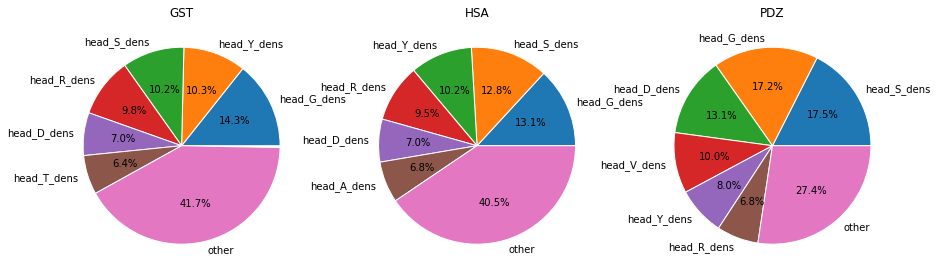

In [28]:
plt.figure(figsize=(15,8))
plt.subplot(131)
aa,aa_counts = counts(GST_Unique_CDR3_HighpH[GST_Unique_CDR3_HighpH['HighpH']==2])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST")
plt.subplot(132)
aa,aa_counts = counts(HSA_Unique_CDR3_HighpH[HSA_Unique_CDR3_HighpH['HighpH']==2])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("HSA")
plt.subplot(133)
aa,aa_counts = counts(Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("PDZ")
#plt.savefig("PieChart AA composition comparison antigens.svg",format='svg')

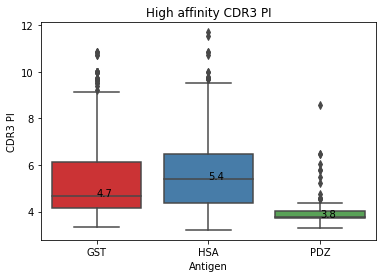

In [123]:
gst_cdr3_pi =GST_Unique_CDR3_HighpH[GST_Unique_CDR3_HighpH['HighpH']==2]['CDR3 PI'].values
hsa_cdr3_pi =HSA_Unique_CDR3_HighpH[HSA_Unique_CDR3_HighpH['HighpH']==2]['CDR3 PI'].values
pdz_cdr3_pi =Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3 PI'].values
pi_data = np.concatenate([gst_cdr3_pi,hsa_cdr3_pi,pdz_cdr3_pi])
labels = np.concatenate([np.repeat("GST",len(gst_cdr3_pi)),np.repeat("HSA",len(hsa_cdr3_pi)),np.repeat("PDZ",len(pdz_cdr3_pi))])
data = pd.DataFrame({"CDR3 PI":pi_data,"Antigen":labels})

sns.boxplot(x='Antigen',y='CDR3 PI',data= data,palette='Set1')
plt.text(0,np.median(gst_cdr3_pi),str(round(np.median(gst_cdr3_pi),1))  )
plt.text(1,np.median(hsa_cdr3_pi),str(round(np.median(hsa_cdr3_pi),1))  )
plt.text(2,np.median(pdz_cdr3_pi),str(round(np.median(pdz_cdr3_pi),1))  )
plt.title("High affinity CDR3 PI")
plt.savefig("PDZ_Figures\\CDR3 PI comparison.svg",format='svg')




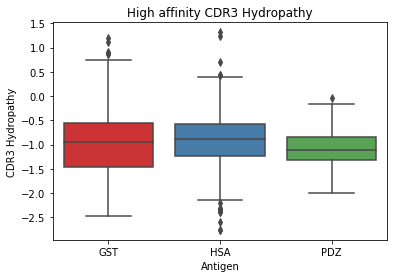

In [99]:
gst_cdr3_hydro =GST_Unique_CDR3_HighpH[GST_Unique_CDR3_HighpH['HighpH']==2]['CDR3 Hydropathy'].values
hsa_cdr3_hydro =HSA_Unique_CDR3_HighpH[HSA_Unique_CDR3_HighpH['HighpH']==2]['CDR3 Hydropathy'].values
pdz_cdr3_hydro =Unique_CDR3_HighpH[Unique_CDR3_HighpH['highph']==2]['CDR3 Hydropathy'].values
hydro_data = np.concatenate([gst_cdr3_hydro,hsa_cdr3_hydro,pdz_cdr3_hydro])
labels = np.concatenate([np.repeat("GST",len(gst_cdr3_hydro)),np.repeat("HSA",len(hsa_cdr3_hydro)),np.repeat("PDZ",len(pdz_cdr3_hydro))])
data = pd.DataFrame({"CDR3 Hydropathy":hydro_data,"Antigen":labels})

sns.boxplot(x='Antigen',y='CDR3 Hydropathy',data= data,palette='Set1')
plt.title("High affinity CDR3 Hydropathy")
plt.savefig("PDZ_Figures\\CDR3 Hydropathy comparison.svg",format='svg')

# CDR1 Comparison

In [344]:
HSA_Unique_CDR1_HighpH = pd.read_csv("HSA_Unique_CDR1_HighpH.csv")
GST_Unique_CDR1_HighpH = pd.read_csv("GST_Unique_CDR1_HighpH.csv")
PDZ_Unique_CDR1_HighpH = Unique_CDR1_HighpH

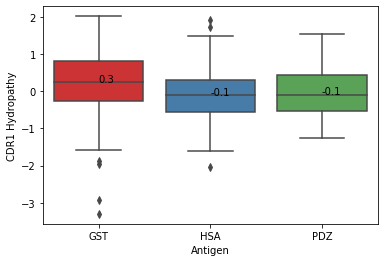

In [352]:
gst_cdr1_hydro =GST_Unique_CDR1_HighpH[GST_Unique_CDR1_HighpH['HighpH']==2]['CDR1 Hydropathy'].values
hsa_cdr1_hydro =HSA_Unique_CDR1_HighpH[HSA_Unique_CDR1_HighpH['HighpH']==2]['CDR1 Hydropathy'].values
pdz_cdr1_hydro =Unique_CDR1_HighpH[Unique_CDR1_HighpH['highph']==2]['CDR1 Hydropathy'].values
hydro_data = np.concatenate([gst_cdr1_hydro,hsa_cdr1_hydro,pdz_cdr1_hydro])
labels = np.concatenate([np.repeat("GST",len(gst_cdr1_hydro)),np.repeat("HSA",len(hsa_cdr1_hydro)),np.repeat("PDZ",len(pdz_cdr1_hydro))])
data = pd.DataFrame({"CDR1 Hydropathy":hydro_data,"Antigen":labels})
plt.text(0,np.median(gst_cdr1_hydro),str(round(np.median(gst_cdr1_hydro),1))  )
plt.text(1,np.median(hsa_cdr1_hydro),str(round(np.median(hsa_cdr1_hydro),1))  )
plt.text(2,np.median(pdz_cdr1_hydro),str(round(np.median(pdz_cdr1_hydro),1))  )
sns.boxplot(x='Antigen',y='CDR1 Hydropathy',data= data,palette='Set1')
plt.savefig("PDZ_Figures\\CDR1 Hydropathy comparison.svg",format='svg')

In [ ]:
gst_cdr1_pi =GST_Unique_CDR1_HighpH[GST_Unique_CDR1_HighpH['HighpH']==2]['CDR1 PI'].values
hsa_cdr1_pi =HSA_Unique_CDR1_HighpH[HSA_Unique_CDR1_HighpH['HighpH']==2]['CDR1 PI'].values
pdz_cdr1_pi =PDZ_Unique_CDR1_HighpH[PDZ_Unique_CDR1_HighpH['highph']==2]['CDR1 PI'].values
pi_data = np.concatenate([gst_cdr1_pi,hsa_cdr1_pi,pdz_cdr1_pi])
labels = np.concatenate([np.repeat("GST",len(gst_cdr1_pi)),np.repeat("HSA",len(hsa_cdr1_pi)),np.repeat("PDZ",len(pdz_cdr1_pi))])
data = pd.DataFrame({"CDR1 PI":pi_data,"Antigen":labels})

sns.boxplot(x='Antigen',y='CDR1 PI',data= data,palette='Set1')
plt.text(0,np.median(gst_cdr1_pi),str(round(np.median(gst_cdr1_pi),1))  )
plt.text(1,np.median(hsa_cdr1_pi),str(round(np.median(hsa_cdr1_pi),1))  )
plt.text(2,np.median(pdz_cdr1_pi),str(round(np.median(pdz_cdr1_pi),1))  )
plt.title("High affinity CDR1 PI")
plt.savefig("PDZ_Figures\\CDR1 PI comparison.svg",format='svg')

# CDR2 Comparison

In [339]:
HSA_Unique_CDR2_HighpH = pd.read_csv("HSA_Unique_CDR2_HighpH.csv")
GST_Unique_CDR2_HighpH = pd.read_csv("GST_Unique_CDR2_HighpH.csv")
PDZ_Unique_CDR2_HighpH = Unique_CDR2_HighpH

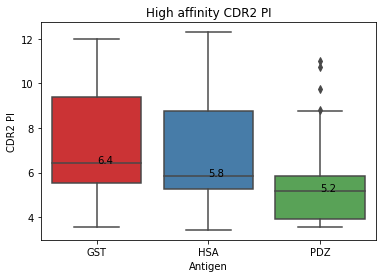

In [346]:
gst_cdr2_pi =GST_Unique_CDR2_HighpH[GST_Unique_CDR2_HighpH['HighpH']==2]['CDR2 PI'].values
hsa_cdr2_pi =HSA_Unique_CDR2_HighpH[HSA_Unique_CDR2_HighpH['HighpH']==2]['CDR2 PI'].values
pdz_cdr2_pi =PDZ_Unique_CDR2_HighpH[PDZ_Unique_CDR2_HighpH['highph']==2]['CDR2 PI'].values
pi_data = np.concatenate([gst_cdr2_pi,hsa_cdr2_pi,pdz_cdr2_pi])
labels = np.concatenate([np.repeat("GST",len(gst_cdr2_pi)),np.repeat("HSA",len(hsa_cdr2_pi)),np.repeat("PDZ",len(pdz_cdr2_pi))])
data = pd.DataFrame({"CDR2 PI":pi_data,"Antigen":labels})

sns.boxplot(x='Antigen',y='CDR2 PI',data= data,palette='Set1')
plt.text(0,np.median(gst_cdr2_pi),str(round(np.median(gst_cdr2_pi),1))  )
plt.text(1,np.median(hsa_cdr2_pi),str(round(np.median(hsa_cdr2_pi),1))  )
plt.text(2,np.median(pdz_cdr2_pi),str(round(np.median(pdz_cdr2_pi),1))  )
plt.title("High affinity CDR2 PI")
plt.savefig("PDZ_Figures\\CDR2 PI comparison.svg",format='svg')


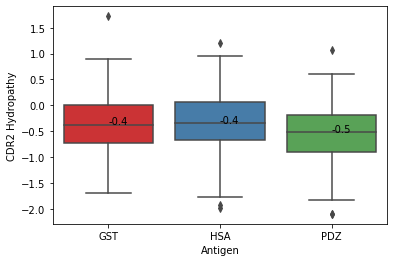

In [354]:
gst_cdr2_hydro =GST_Unique_CDR2_HighpH[GST_Unique_CDR2_HighpH['HighpH']==2]['CDR2 Hydropathy'].values
hsa_cdr2_hydro =HSA_Unique_CDR2_HighpH[HSA_Unique_CDR2_HighpH['HighpH']==2]['CDR2 Hydropathy'].values
pdz_cdr2_hydro =Unique_CDR2_HighpH[Unique_CDR2_HighpH['highph']==2]['CDR2 Hydropathy'].values
hydro_data = np.concatenate([gst_cdr2_hydro,hsa_cdr2_hydro,pdz_cdr2_hydro])
labels = np.concatenate([np.repeat("GST",len(gst_cdr2_hydro)),np.repeat("HSA",len(hsa_cdr2_hydro)),np.repeat("PDZ",len(pdz_cdr2_hydro))])
data = pd.DataFrame({"CDR2 Hydropathy":hydro_data,"Antigen":labels})
plt.text(0,np.median(gst_cdr2_hydro),str(round(np.median(gst_cdr2_hydro),1))  )
plt.text(1,np.median(hsa_cdr2_hydro),str(round(np.median(hsa_cdr2_hydro),1))  )
plt.text(2,np.median(pdz_cdr2_hydro),str(round(np.median(pdz_cdr2_hydro),1))  )
sns.boxplot(x='Antigen',y='CDR2 Hydropathy',data= data,palette='Set1')
plt.savefig("PDZ_Figures\\CDR2 Hydropathy comparison.svg",format='svg')

## CDR Comparison

In [14]:
GST_CDR = pd.read_csv("GST_Unique_CDR_HighpH.csv")
HSA_CDR = pd.read_csv("HSA_Unique_CDR_HighpH.csv")
PDZ_CDR = Unique_CDR_HighpH

In [15]:
GST_CDR['CDR Hydropathy'] = GST_CDR['CDR'].apply(lambda x: ProteinAnalysis(x).gravy())
HSA_CDR['CDR Hydropathy'] = HSA_CDR['CDR'].apply(lambda x: ProteinAnalysis(x).gravy())
PDZ_CDR['CDR Hydropathy'] = PDZ_CDR['CDR'].apply(lambda x: ProteinAnalysis(x).gravy())

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
HighpH_GST = GST_CDR[GST_CDR['HighpH']==2] 
HighpH_HSA = HSA_CDR[HSA_CDR['HighpH']==2]
HighpH_PDZ = PDZ_CDR[PDZ_CDR['highph']==2]

In [17]:
HighpH_PDZ['Head_CDR3'] = HighpH_PDZ['CDR3'].apply(lambda x:x[:-3])

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
def count_charged(data):
    total_len = data['Head_CDR3'].astype(str).apply(lambda x:len(x)).sum()
    KR = 100*(data['Head_CDR3'].astype(str).apply(lambda x: x.count("R")+x.count("K")+x.count("H")).sum())/total_len
    DE = 100*(data['Head_CDR3'].astype(str).apply(lambda x: x.count("D")+x.count("E")).sum())/total_len
    return KR,DE

In [58]:
def charge_diff(data):
    data2 = data[~data['Head_CDR3'].isnull()]
    return data2['Head_CDR3'].apply(lambda x:x.count("R")+x.count("K")+x.count("H")-(x.count("D")+x.count("E"))).values

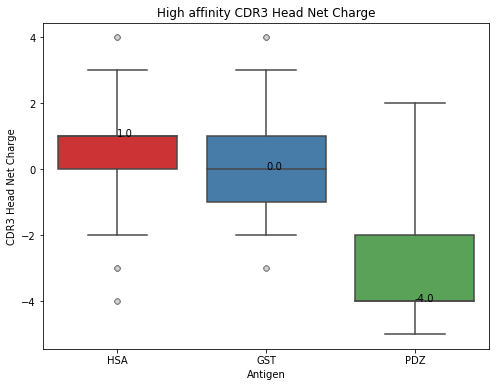

In [64]:
plt.figure(figsize=(8,6))
gst_head_cdr3_charge_diff =charge_diff(HighpH_GST)
hsa_head_cdr3_charge_diff =charge_diff(HighpH_HSA)
pdz_head_cdr3_charge_diff =charge_diff(HighpH_PDZ)
charge_diff_data = np.concatenate([hsa_head_cdr3_charge_diff,gst_head_cdr3_charge_diff,pdz_head_cdr3_charge_diff])
labels = np.concatenate([np.repeat("HSA",len(hsa_head_cdr3_charge_diff)),
                        np.repeat("GST",len(gst_head_cdr3_charge_diff)),
                         np.repeat("PDZ",len(pdz_head_cdr3_charge_diff))])
data = pd.DataFrame({"CDR3 Head Net Charge":charge_diff_data,"Antigen":labels})

flierprops = dict(marker='o', markerfacecolor='lightgrey', markersize=5, linestyle='none',linewidth=0,markeredgecolor='grey',alpha=0.5)

sns.boxplot(x='Antigen',y='CDR3 Head Net Charge',data= data,palette='Set1',whis=(1,99),flierprops=flierprops)
#sns.swarmplot(x="Antigen", y="CDR3 Head Net Charge", data=data, color=".25")

plt.text(0,np.median(hsa_head_cdr3_charge_diff),str(round(np.median(hsa_head_cdr3_charge_diff),1)))
plt.text(1,np.median(gst_head_cdr3_charge_diff),str(round(np.median(gst_head_cdr3_charge_diff),1)))
plt.text(2,np.median(pdz_head_cdr3_charge_diff),str(round(np.median(pdz_head_cdr3_charge_diff),1)))

plt.title("High affinity CDR3 Head Net Charge")
plt.savefig("PDZ_Figures\\CDR_CDR3NetCharge_Comparison_3antigens.svg",format='svg')


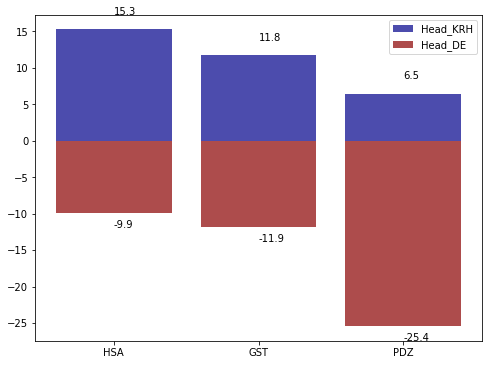

In [19]:
plt.figure(figsize=(8,6))
hsa_krh,hsa_de = count_charged(HighpH_HSA)
gst_krh,gst_de = count_charged(HighpH_GST)
pdz_krh,pdz_de = count_charged(HighpH_PDZ)

plt.bar(["HSA","GST","PDZ"],[hsa_krh,gst_krh,pdz_krh],color='darkblue',alpha=0.7,label='Head_KRH')
for _x,val in enumerate([hsa_krh,gst_krh,pdz_krh]):
    plt.text(_x,val+2,round(val,1))
    
plt.bar(["HSA","GST","PDZ"],[-1*hsa_de,-1*gst_de,-1*pdz_de],color='darkred',alpha=0.7,label='Head_DE')
for _x,val in enumerate([-1*hsa_de,-1*gst_de,-1*pdz_de]):
    plt.text(_x,val-2,round(val,1))
plt.legend()
#plt.savefig("CDR_charged_resi_Comparison_3antigens.svg",format='svg')

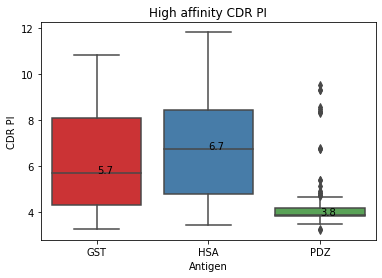

In [30]:
gst_pi =HighpH_GST['CDR PI'].values
hsa_pi =HighpH_HSA['CDR PI'].values
pdz_pi =HighpH_PDZ['CDR PI'].values
pi_data = np.concatenate([gst_pi,hsa_pi,pdz_pi])
labels = np.concatenate([np.repeat("GST",len(gst_pi)),np.repeat("HSA",len(hsa_pi)),np.repeat("PDZ",len(pdz_pi))])
data = pd.DataFrame({"CDR PI":pi_data,"Antigen":labels})


sns.boxplot(x='Antigen',y='CDR PI',data= data,palette='Set1')

plt.text(0,np.median(gst_pi),str(round(np.median(gst_pi),1)))
plt.text(1,np.median(hsa_pi),str(round(np.median(hsa_pi),1)))
plt.text(2,np.median(pdz_pi),str(round(np.median(pdz_pi),1)))

plt.title("High affinity CDR PI")
plt.savefig("PDZ_Figures\\CDR PI comparison.svg",format='svg')

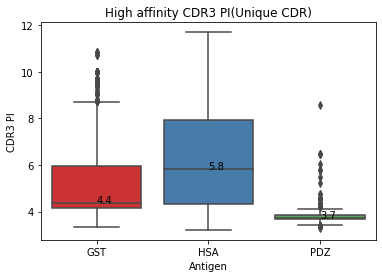

In [33]:
gst_pi =HighpH_GST['CDR3 PI'].values
hsa_pi =HighpH_HSA['CDR3 PI'].values
pdz_pi =HighpH_PDZ['CDR3 PI'].values
pi_data = np.concatenate([gst_pi,hsa_pi,pdz_pi])
labels = np.concatenate([np.repeat("GST",len(gst_pi)),np.repeat("HSA",len(hsa_pi)),np.repeat("PDZ",len(pdz_pi))])
data = pd.DataFrame({"CDR3 PI":pi_data,"Antigen":labels})


sns.boxplot(x='Antigen',y='CDR3 PI',data= data,palette='Set1')

plt.text(0,np.median(gst_pi),str(round(np.median(gst_pi),1)))
plt.text(1,np.median(hsa_pi),str(round(np.median(hsa_pi),1)))
plt.text(2,np.median(pdz_pi),str(round(np.median(pdz_pi),1)))

plt.title("High affinity CDR3 PI(Unique CDR)")
plt.savefig("PDZ_Figures\\CDR3 PI comparison(Unique CDR).svg",format='svg')

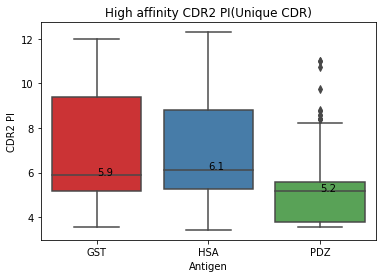

In [131]:
gst_pi =HighpH_GST['CDR2 PI'].values
hsa_pi =HighpH_HSA['CDR2 PI'].values
pdz_pi =HighpH_PDZ['CDR2 PI'].values
pi_data = np.concatenate([gst_pi,hsa_pi,pdz_pi])
labels = np.concatenate([np.repeat("GST",len(gst_pi)),np.repeat("HSA",len(hsa_pi)),np.repeat("PDZ",len(pdz_pi))])
data = pd.DataFrame({"CDR2 PI":pi_data,"Antigen":labels})


sns.boxplot(x='Antigen',y='CDR2 PI',data= data,palette='Set1')

plt.text(0,np.median(gst_pi),str(round(np.median(gst_pi),1)))
plt.text(1,np.median(hsa_pi),str(round(np.median(hsa_pi),1)))
plt.text(2,np.median(pdz_pi),str(round(np.median(pdz_pi),1)))

plt.title("High affinity CDR2 PI(Unique CDR)")
plt.savefig("PDZ_Figures\\CDR2 PI comparison(Unique CDR).svg",format='svg')

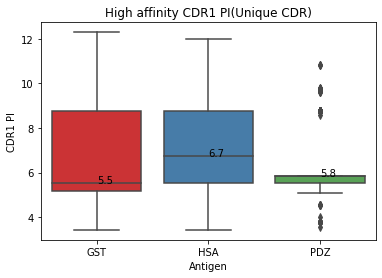

In [132]:
gst_pi =HighpH_GST['CDR1 PI'].values
hsa_pi =HighpH_HSA['CDR1 PI'].values
pdz_pi =HighpH_PDZ['CDR1 PI'].values
pi_data = np.concatenate([gst_pi,hsa_pi,pdz_pi])
labels = np.concatenate([np.repeat("GST",len(gst_pi)),np.repeat("HSA",len(hsa_pi)),np.repeat("PDZ",len(pdz_pi))])
data = pd.DataFrame({"CDR1 PI":pi_data,"Antigen":labels})


sns.boxplot(x='Antigen',y='CDR1 PI',data= data,palette='Set1')

plt.text(0,np.median(gst_pi),str(round(np.median(gst_pi),1)))
plt.text(1,np.median(hsa_pi),str(round(np.median(hsa_pi),1)))
plt.text(2,np.median(pdz_pi),str(round(np.median(pdz_pi),1)))

plt.title("High affinity CDR1 PI(Unique CDR)")
plt.savefig("PDZ_Figures\\CDR1 PI comparison(Unique CDR).svg",format='svg')

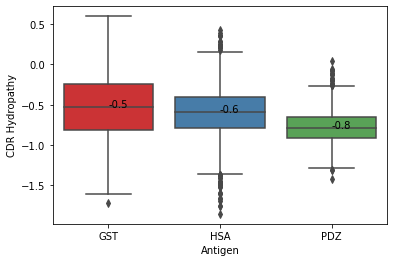

In [361]:
gst_cdr_hydro =GST_CDR[GST_CDR['HighpH']==2]['CDR Hydropathy'].values
hsa_cdr_hydro =HSA_CDR[HSA_CDR['HighpH']==2]['CDR Hydropathy'].values
pdz_cdr_hydro =PDZ_CDR[PDZ_CDR['highph']==2]['CDR Hydropathy'].values
hydro_data = np.concatenate([gst_cdr_hydro,hsa_cdr_hydro,pdz_cdr_hydro])
labels = np.concatenate([np.repeat("GST",len(gst_cdr_hydro)),np.repeat("HSA",len(hsa_cdr_hydro)),np.repeat("PDZ",len(pdz_cdr_hydro))])
data = pd.DataFrame({"CDR Hydropathy":hydro_data,"Antigen":labels})
plt.text(0,np.median(gst_cdr_hydro),str(round(np.median(gst_cdr_hydro),1))  )
plt.text(1,np.median(hsa_cdr_hydro),str(round(np.median(hsa_cdr_hydro),1))  )
plt.text(2,np.median(pdz_cdr_hydro),str(round(np.median(pdz_cdr_hydro),1))  )
sns.boxplot(x='Antigen',y='CDR Hydropathy',data= data,palette='Set1')
plt.savefig("PDZ_Figures\\CDR Hydropathy comparison.svg",format='svg')

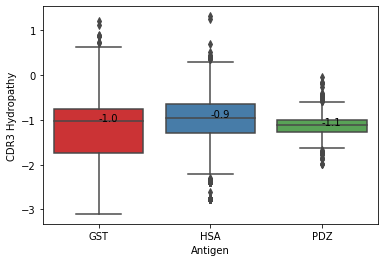

In [32]:
gst_cdr_hydro =GST_CDR[GST_CDR['HighpH']==2]['CDR3 Hydropathy'].values
hsa_cdr_hydro =HSA_CDR[HSA_CDR['HighpH']==2]['CDR3 Hydropathy'].values
pdz_cdr_hydro =PDZ_CDR[PDZ_CDR['highph']==2]['CDR3 Hydropathy'].values
hydro_data = np.concatenate([gst_cdr_hydro,hsa_cdr_hydro,pdz_cdr_hydro])
labels = np.concatenate([np.repeat("GST",len(gst_cdr_hydro)),np.repeat("HSA",len(hsa_cdr_hydro)),np.repeat("PDZ",len(pdz_cdr_hydro))])
data = pd.DataFrame({"CDR3 Hydropathy":hydro_data,"Antigen":labels})
plt.text(0,np.median(gst_cdr_hydro),str(round(np.median(gst_cdr_hydro),1))  )
plt.text(1,np.median(hsa_cdr_hydro),str(round(np.median(hsa_cdr_hydro),1))  )
plt.text(2,np.median(pdz_cdr_hydro),str(round(np.median(pdz_cdr_hydro),1))  )
sns.boxplot(x='Antigen',y='CDR3 Hydropathy',data= data,palette='Set1')
plt.savefig("PDZ_Figures\\CDR3 Hydropathy comparison(Unique CDR).svg",format='svg')

## Sequence PI

In [5]:
GST = pd.read_csv("GST.csv")
HSA = pd.read_csv("HSA.csv")
PDZ = pd.read_csv("PDZ.csv")

In [15]:
HighpH_GST = GST[GST['HighpH']=='2'] 
HighpH_HSA = HSA[HSA['HighpH']=='2']
HighpH_PDZ = PDZ[PDZ['highph']==2]

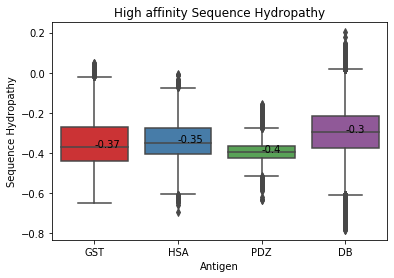

In [20]:
gst_hydro =HighpH_GST['Sequence Hydropathy'].values
hsa_hydro =HighpH_HSA['Sequence Hydropathy'].values
pdz_hydro =HighpH_PDZ['Sequence Hydropathy'].values
hydro_data = np.concatenate([gst_hydro,hsa_hydro,pdz_hydro,HSA_DB_Seq_Hydro])
labels = np.concatenate([np.repeat("GST",len(gst_hydro)),np.repeat("HSA",len(hsa_hydro)),np.repeat("PDZ",len(pdz_hydro)),np.repeat("DB",len(HSA_DB_Seq_Hydro))])
data = pd.DataFrame({"Sequence Hydropathy":hydro_data,"Antigen":labels})


sns.boxplot(x='Antigen',y='Sequence Hydropathy',data= data,palette='Set1')

plt.text(0,np.median(gst_hydro),str(round(np.median(gst_hydro),2)))
plt.text(1,np.median(hsa_hydro),str(round(np.median(hsa_hydro),2)))
plt.text(2,np.median(pdz_hydro),str(round(np.median(pdz_hydro),2)))
plt.text(3,np.median(HSA_DB_Seq_Hydro),str(round(np.median(HSA_DB_Seq_Hydro),1)))


plt.title("High affinity Sequence Hydropathy")
plt.savefig("PDZ_Figures\\Sequence Hydropathy comparison.svg",format='svg')

In [289]:
def draw_hist_line(data,bins,ax,label,color,direction=1):
    h,x = np.histogram(data, bins=np.arange(4,10,bins),weights=np.ones(len(data)) / len(data))
    x = np.array(x[:-1])
    #h = pd.Series(h).rolling(window=2).mean()
    h = gaussian_filter1d(h,1)
    if direction!=1:
        h *= -1
    #ax.plot(x,h,c=color)
    median = round(np.median(data),1)
    ax.fill_between(x,0,h,alpha=0.5,label=label,color=color)
    #print(h)
    #ax.vlines([median,median],[0],[h[median]],color='darkgrey',linestyles='dashed')
    #print(h)
    #plt.text(median,h[(median-3)*10]+0.01,"{}".format(median))

In [147]:
DB_Seq_PI = []
seqs = set()
for record in SeqIO.parse("D:\\ZheS\\database\\GST_BM\\7168_Mito_GST_Fam60a_EGFR_morethan2.fasta","fasta"):
    seq = str(record.seq)
    if len(seq) < 100:
        continue
    DB_Seq_PI.append(ProteinAnalysis(seq).isoelectric_point())
    seqs.add(seq)
for record in SeqIO.parse("D:\\ZheS\\database\\GST_BL\\Mito_BL_01312019_morethan2.fasta","fasta"):
    seq = str(record.seq)
    /*/*en(record.seq)  100:
        continue
    if seq in seqs:
        continue
    DB_Seq_PI.append(ProteinAnalysis(seq).isoelectric_point())  
    seqs.add(seq)

In [156]:
HSA_DB_Seq_PI = []
for record in SeqIO.parse("D:\\ZheS\\database\\HSA\\6503_HSA_cMET_morethan2_042018.fasta","fasta"):
    seq = str(record.seq)
    if len(seq) < 100:
        continue
    HSA_DB_Seq_PI.append(ProteinAnalysis(seq).isoelectric_point())    

In [18]:
HSA_DB_Seq_Hydro = []
for record in SeqIO.parse("D:\\ZheS\\database\\HSA\\6503_HSA_cMET_morethan2_042018.fasta","fasta"):
    seq = str(record.seq)
    if len(seq) < 100:
        continue
    HSA_DB_Seq_Hydro.append(ProteinAnalysis(seq).gravy())    

<Figure size 432x288 with 0 Axes>

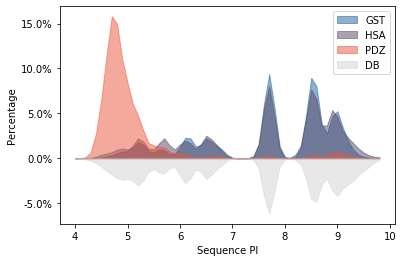

In [291]:
plt.figure()
fig,ax  = plt.subplots(1)
draw_hist_line(gst_pi,0.1,ax,'GST','#20639B',1)
draw_hist_line(hsa_pi,0.1,ax,'HSA','#534666',1)
draw_hist_line(pdz_pi,0.1,ax,'PDZ','#ED553B',1)
draw_hist_line(HSA_DB_Seq_PI,0.1,ax,"DB","lightgrey",0)
ax.set_xlabel('Sequence PI')
ax.set_ylabel('Percentage')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("PDZ_Figures\\Sequence PI distribution comparison(smooth).svg",format='svg')

In [26]:
for aa in 'GASPVTCILNDQKEMHFRYW':
    PDZ_CDR["head_"+aa+"_dens"] = PDZ_CDR['CDR3'].apply(lambda x: x[:-4].count(aa)/(len(x)-4) )
    GST_CDR["head_"+aa+"_dens"] = GST_CDR['CDR3'].apply(lambda x: x[:-4].count(aa)/(len(x)) )
    HSA_CDR["head_"+aa+"_dens"] = HSA_CDR['CDR3'].apply(lambda x: x[:-4].count(aa)/(len(x)-4) )

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

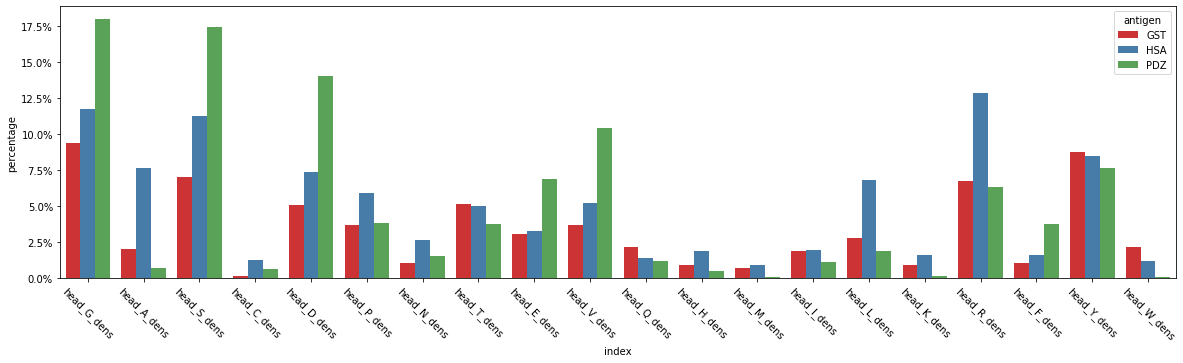

In [27]:

plt.figure(figsize=(20,5))

high_pdz = pd.DataFrame(PDZ_CDR[PDZ_CDR['highph']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)).reset_index()
high_pdz['Antigen'] = np.repeat("PDZ",high_pdz.shape[0])
high_gst = pd.DataFrame(GST_CDR[GST_CDR['HighpH']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)).reset_index()
high_gst['Antigen'] = np.repeat("GST",high_pdz.shape[0])
high_hsa= pd.DataFrame(HSA_CDR[HSA_CDR['HighpH']==2][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)).reset_index()
high_hsa['Antigen'] = np.repeat("HSA",high_pdz.shape[0])

data = pd.concat([high_gst,high_hsa,high_pdz])
data.columns = ['index','percentage','antigen']

sns.barplot(x = "index",y='percentage',hue='antigen',data=data,palette='Set1')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)

#plt.savefig("AA composition comparison antigens.svg",format='svg')

In [53]:
HighpH_GST = HighpH_GST[~HighpH_GST['Head_CDR3'].isnull()]
HighpH_HSA = HighpH_HSA[~HighpH_HSA['Head_CDR3'].isnull()]
HighpH_PDZ = HighpH_PDZ[~HighpH_PDZ['Head_CDR3'].isnull()]

In [98]:
high_gst = pd.DataFrame(HighpH_GST[['head_'+aa for aa in 'GASPVTCILNDQKEMHFRYW']].sum(0)/HighpH_GST['Head_CDR3'].apply(lambda x:len(x)).sum(0)).reset_index()
high_gst['Antigen'] = np.repeat("GST",high_gst.shape[0])
high_hsa = pd.DataFrame(HighpH_HSA[['head_'+aa for aa in 'GASPVTCILNDQKEMHFRYW']].sum(0)/HighpH_HSA['Head_CDR3'].apply(lambda x:len(x)).sum(0)).reset_index()
high_hsa['Antigen'] = np.repeat("HSA",high_hsa.shape[0])
high_pdz = pd.DataFrame(HighpH_PDZ[['head_'+aa for aa in 'GASPVTCILNDQKEMHFRYW']].sum(0)/HighpH_PDZ['Head_CDR3'].apply(lambda x:len(x)).sum(0)).reset_index()
high_pdz['Antigen'] = np.repeat("PDZ",high_hsa.shape[0])


In [115]:
db_aa = pd.read_excel("DB AA Composition.xlsx")
db_aa['Antigen'] = np.repeat("DB",db_aa.shape[0])

In [116]:
db_aa['index'] = db_aa['index'].apply(lambda x: "head_"+x)

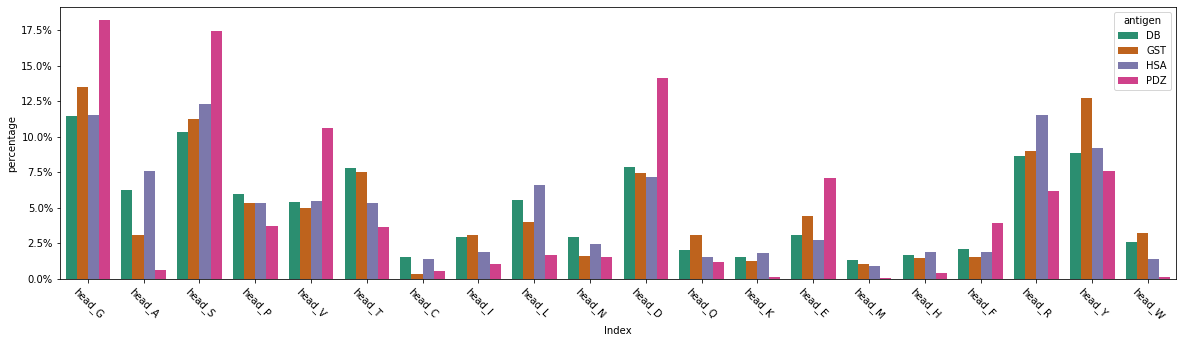

In [128]:
plt.figure(figsize=(20,5))
data = pd.concat([db_aa,high_gst,high_hsa,high_pdz])
data.columns = ['Index','percentage','antigen']

sns.barplot(x = "Index",y='percentage',hue='antigen',data=data,palette='Dark2')


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.savefig("PDZ_Figures/CDR3 AA composition comparison antigens(UniqueCDR).svg",format='svg')